In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [3]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [12]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print('')

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [13]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print('')

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [52]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [25]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [31]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[5 6 7 8] [9]
[4 5 6 7] [8]
[2 3 4 5] [6]
[3 4 5 6] [7]
[1 2 3 4] [5]
[0 1 2 3] [4]


In [39]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[[5 6 7 8]
 [1 2 3 4]] [[9]
 [5]]
[[2 3 4 5]
 [3 4 5 6]] [[6]
 [7]]
[[4 5 6 7]
 [0 1 2 3]] [[8]
 [4]]


In [62]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [63]:
def windowed_gen(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

In [74]:
dataset = windowed_gen(series, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

model = tf.keras.models.Sequential([l0])
model.summary()

# model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.compile(loss='mse', optimizer='adam')
model.fit(dataset, epochs=200)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
46/46 [==============================] - 0s 1ms/step - loss: 1004.2676
Epoch 2/200
46/46 [==============================] - 0s 1ms/step - loss: 132.4709
Epoch 3/200
46/46 [==============================] - 0s 1ms/step - loss: 128.0085
Epoch 4/200
46/46 [==============================] - 0s 1ms/step - loss: 127.0921
Epoch 5/200
46/46 [==============================] - 0s 1ms/step - loss: 126.4281
Epoch 6/200
46/46 [==============================] - 0s 1ms/step - loss: 125.1873
Epoch 7/200
46/46 [==============================] - 0s 1ms/step - loss: 12

Epoch 192/200
46/46 [==============================] - 0s 1ms/step - loss: 45.8593
Epoch 193/200
46/46 [==============================] - 0s 1ms/step - loss: 44.8494
Epoch 194/200
46/46 [==============================] - 0s 1ms/step - loss: 44.3985
Epoch 195/200
46/46 [==============================] - 0s 1ms/step - loss: 44.5360
Epoch 196/200
46/46 [==============================] - 0s 1ms/step - loss: 45.4895
Epoch 197/200
46/46 [==============================] - 0s 1ms/step - loss: 44.3387
Epoch 198/200
46/46 [==============================] - 0s 1ms/step - loss: 44.9379
Epoch 199/200
46/46 [==============================] - 0s 1ms/step - loss: 44.3926
Epoch 200/200
46/46 [==============================] - 0s 1ms/step - loss: 45.0732


In [76]:
print('layers weights -> {}'.format(l0.get_weights()))

layers weights -> [array([[ 0.03036107],
       [-0.06729926],
       [ 0.01316425],
       [-0.05419091],
       [ 0.05871116],
       [ 0.00346638],
       [ 0.02628556],
       [ 0.02664142],
       [-0.0352327 ],
       [ 0.05595895],
       [-0.06228257],
       [-0.06931806],
       [ 0.02603823],
       [ 0.09993984],
       [ 0.03991016],
       [ 0.01034538],
       [-0.02110285],
       [ 0.23516811],
       [ 0.28316778],
       [ 0.40186334]], dtype=float32), array([0.4516001], dtype=float32)]


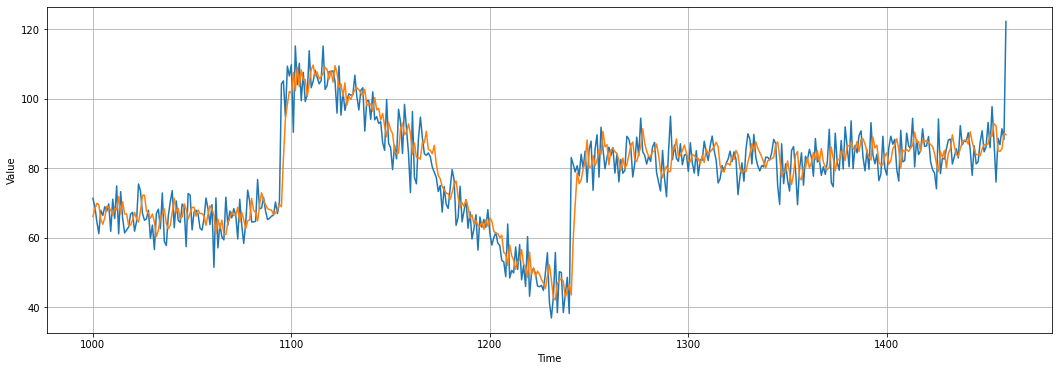

In [94]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(18, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [93]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9878645